In [132]:
import numpy as np
import scipy as sc
import pandas as pd
from scipy import stats, interpolate
import matplotlib.pyplot as plt
import QuantLib as ql
from datetime import datetime, timedelta, date
from openbb_terminal.sdk import openbb
import pickle
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)

In [133]:
with open('spread.pickle', 'rb') as file:
    spread = pickle.load(file)

In [134]:
spread = pd.DataFrame(spread).dropna()
spread

,Close
Date,
2013-07-19,-0.0033
2013-07-22,-0.0054
2013-07-23,-0.0030
2013-07-24,-0.0008
2013-07-25,0.0014
...,...
2023-11-24,-0.0004
2023-11-27,0.0064
2023-11-28,-0.0143


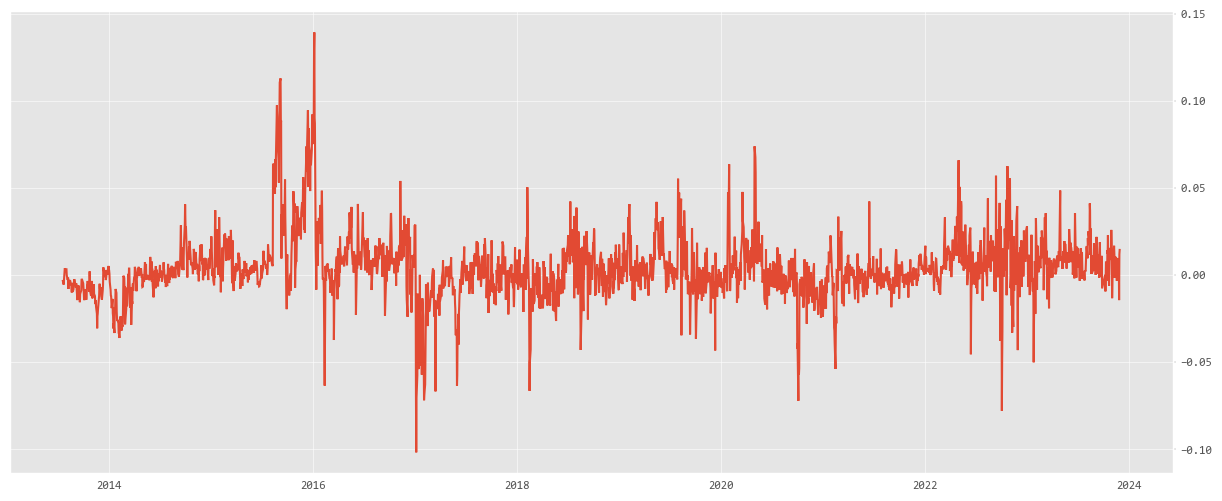

In [136]:
plt.plot(spread);

In [137]:
spread_vol = spread["Close"].std()*np.sqrt(252)
spread_vol #Annualized

0.29039026746156427

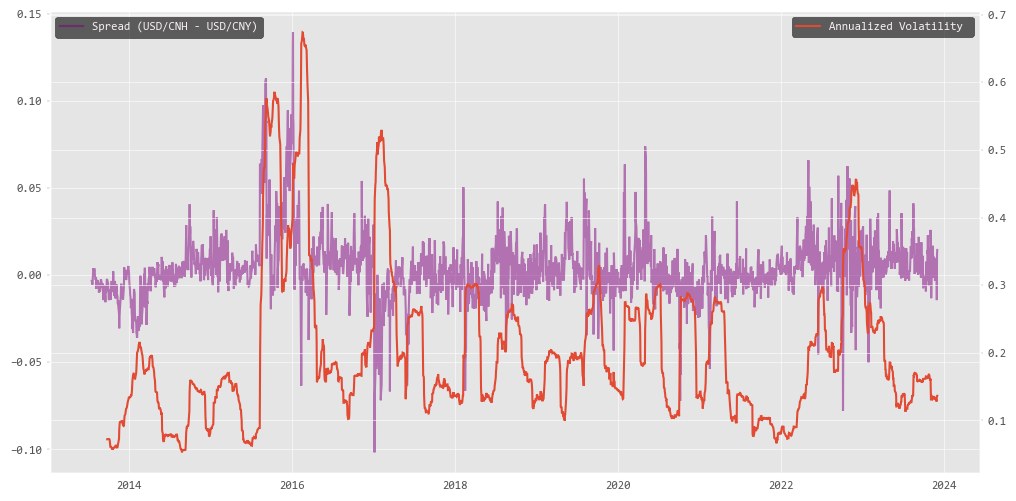

In [147]:
fig, ax1 = plt.subplots(figsize=(12, 6))
spread_vol_50 = spread.rolling(window = 50).std().dropna() * np.sqrt(252)

ax1.plot(spread, label='Spread (USD/CNH - USD/CNY)', color = "purple", alpha =0.5)
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(spread_vol_50, label='Annualized Volatility ')
ax2.legend(loc='upper right');

<Axes: xlabel='Date'>

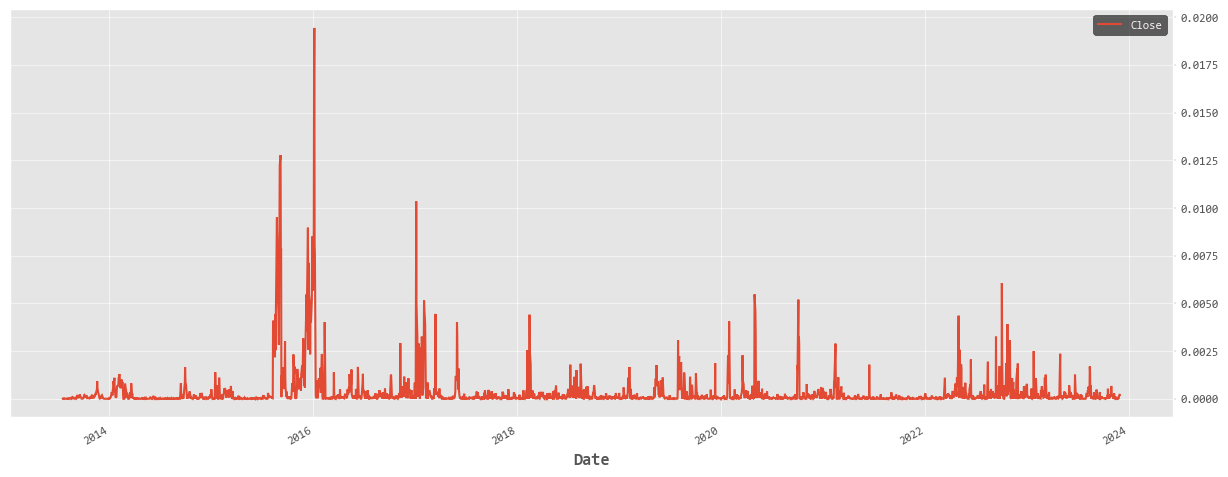

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
(spread**2).plot(ax=ax)


In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

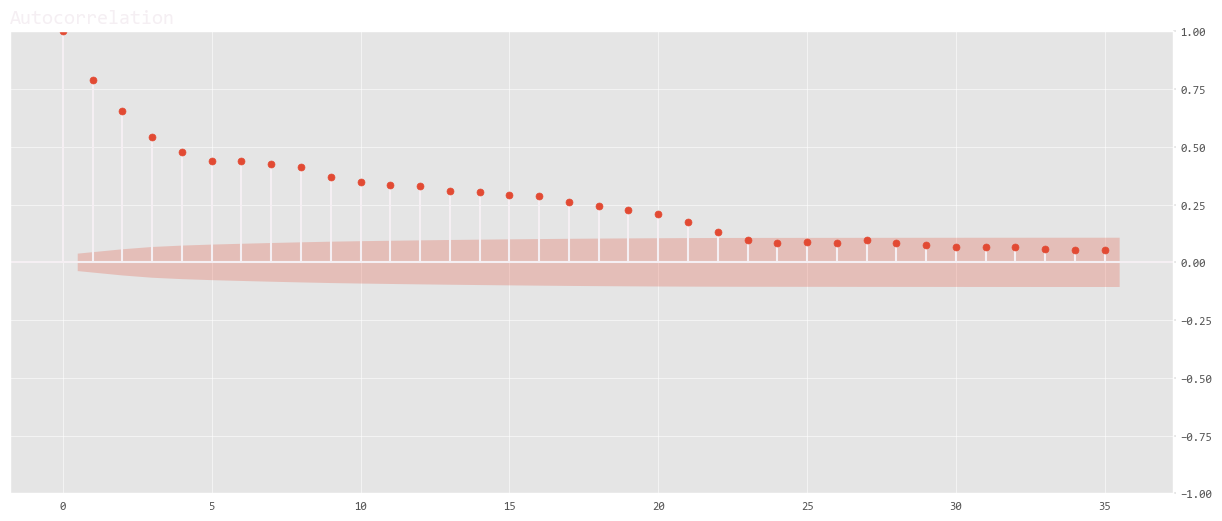

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(spread**2, ax =ax);

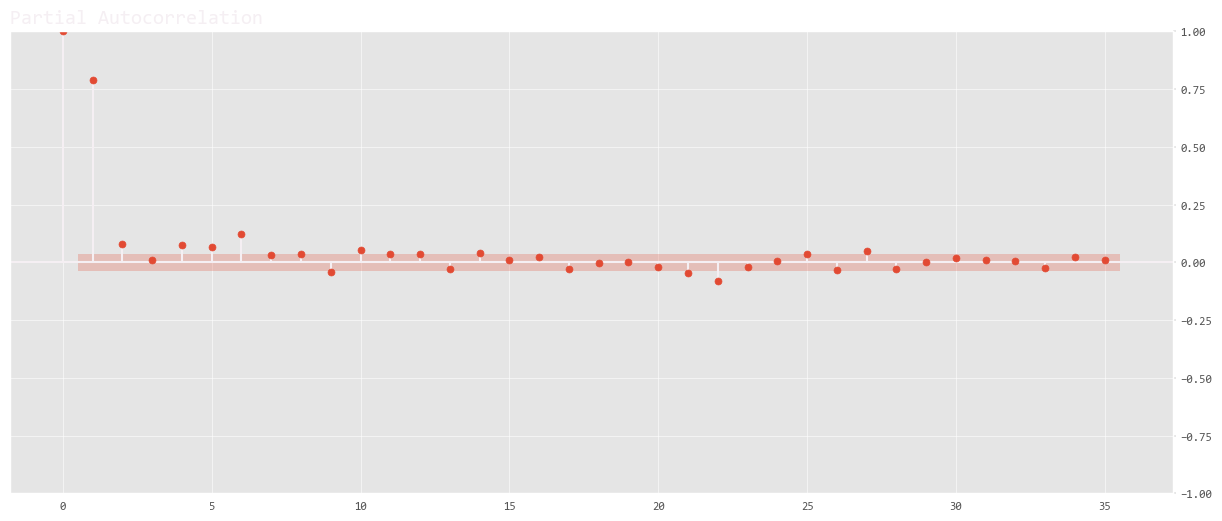

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(spread**2, ax =ax);

In [29]:
cutoff_test = int(len(spread)*0.8)
y_spread_train = spread.iloc[:cutoff_test]

In [120]:
model = arch_model(
    y_spread_train,
    p=1,
    q=1,
    rescale =False
).fit(disp = 0)
print("model type:", type(model))

model type: <class 'arch.univariate.base.ARCHModelResult'>


In [124]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6375.02
Distribution:                  Normal   AIC:                          -12742.0
Method:            Maximum Likelihood   BIC:                          -12719.3
                                        No. Observations:                 2158
Date:                Thu, Nov 30 2023   Df Residuals:                     2157
Time:                        20:23:50   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.4249e-04  5.579e-06     97.245      0.000 [5.316e-04,5.534e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      7.2737e-06  6.944e-12  1.047e+06      0.000 [7.274e-06,7.274e-06]
alpha[1]       0.2000  2.235e-02      8.950  3.564e-19     [  0.156,  0.244]
beta[1]        0.7800  1.678e-02     46.487      0.000     [  0.747,  0.813]
============================================================================

Covariance estimator: robust
"""

<Axes: xlabel='Date'>

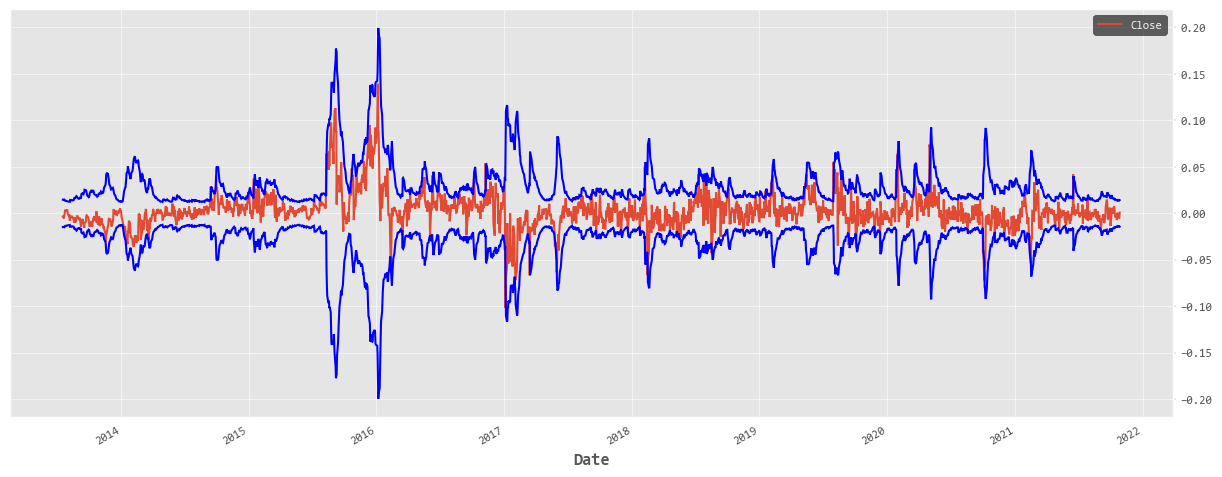

In [171]:
fig, ax = plt.subplots(figsize=(15, 6))
y_spread_train.plot(ax=ax, label ="daily returns")


(2*model.conditional_volatility).plot(
ax=ax, color = "blue", linewidth = 1.5, label = "2 STD volatility"
)

(-2*model.conditional_volatility).plot(
ax=ax, color = "blue", linewidth = 1.5
)

In [164]:
df_eror = pd.merge(model.conditional_volatility,spread, left_index=True, right_index=True, how='inner' )
df_eror["error"] = df_eror["cond_vol"] - df_eror["Close"]

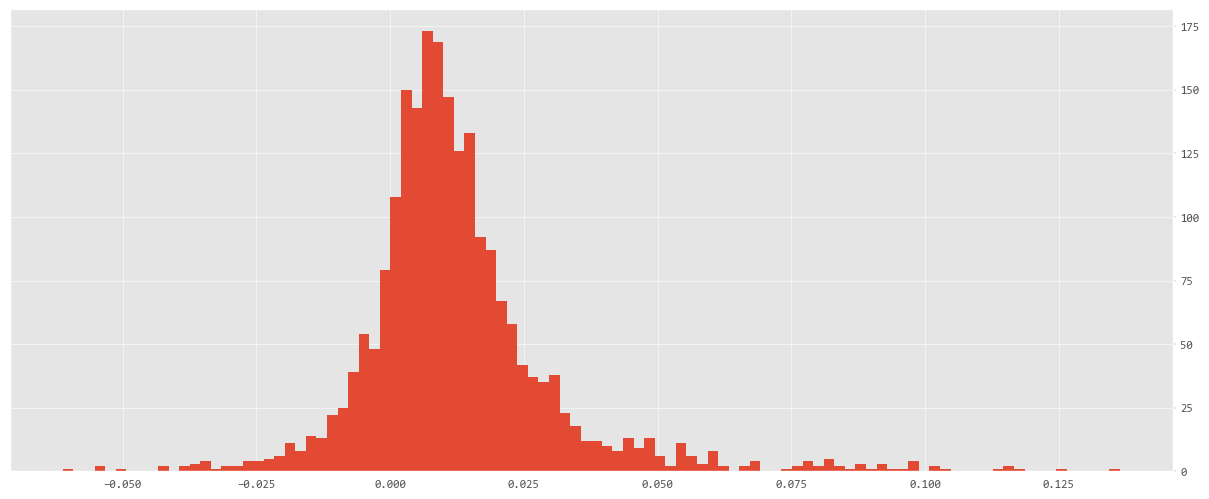

In [168]:
plt.hist(df_eror["error"], bins = 100);

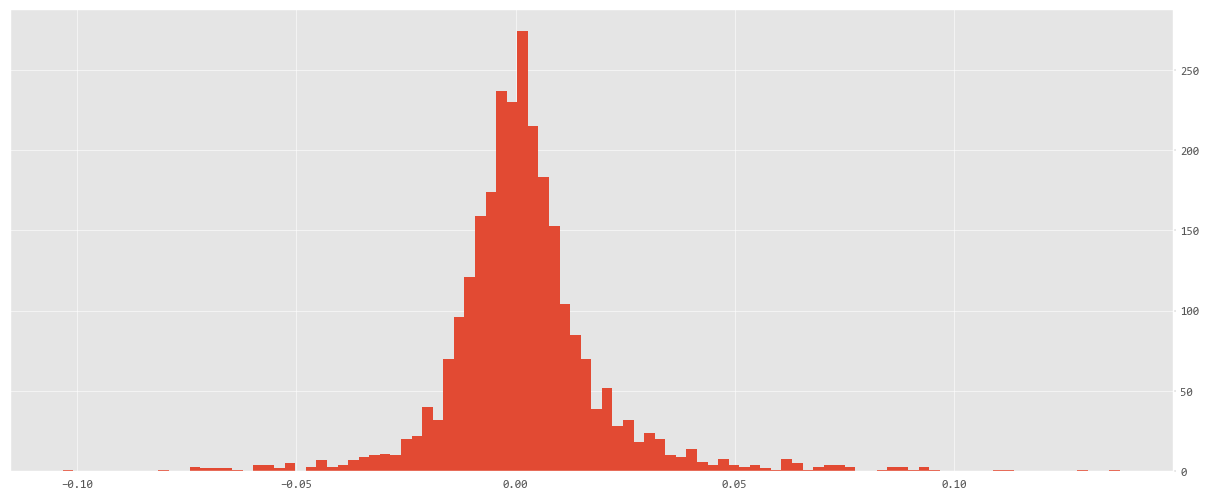

In [222]:
residualss = model.resid
plt.hist(residualss, bins = 100);

count    2158.000000
mean        0.064202
std         0.981410
min        -5.145025
25%        -0.575262
50%         0.072010
75%         0.659664
max         6.868946
Name: std_resid, dtype: float64


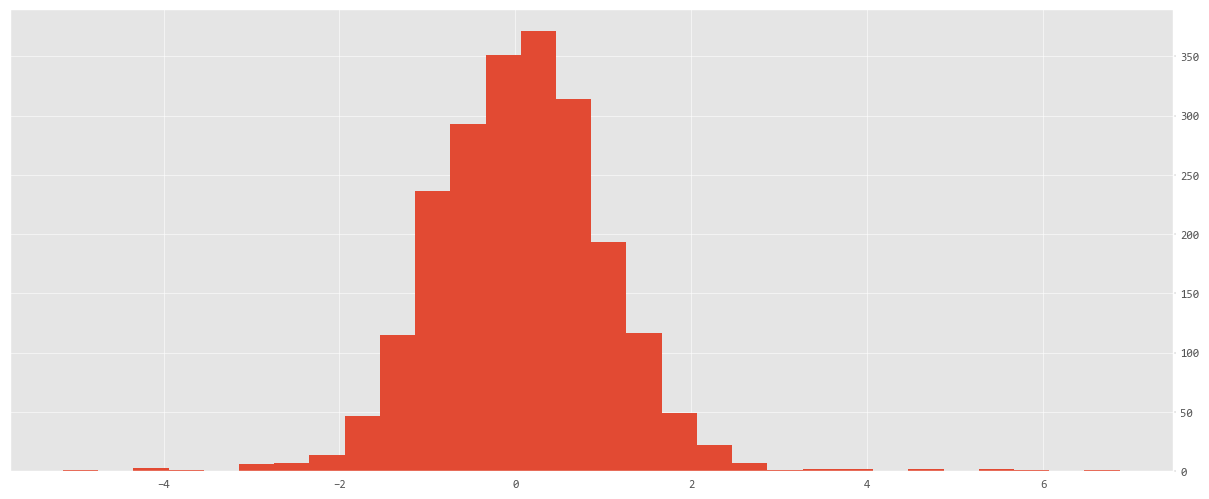

In [154]:
print(model.std_resid.describe())
plt.hist(model.std_resid, bins = 30)
plt.show()

In [155]:
forecast = model.forecast(start=0, horizon=30)
forecast_volatility = forecast.variance.dropna().values.flatten()

In [156]:
forecast_volatility

array([3.77120179e-05, 4.42314249e-05, 5.06204408e-05, ...,
       1.80221507e-04, 1.83890660e-04, 1.87486427e-04])

<Axes: xlabel='Date'>

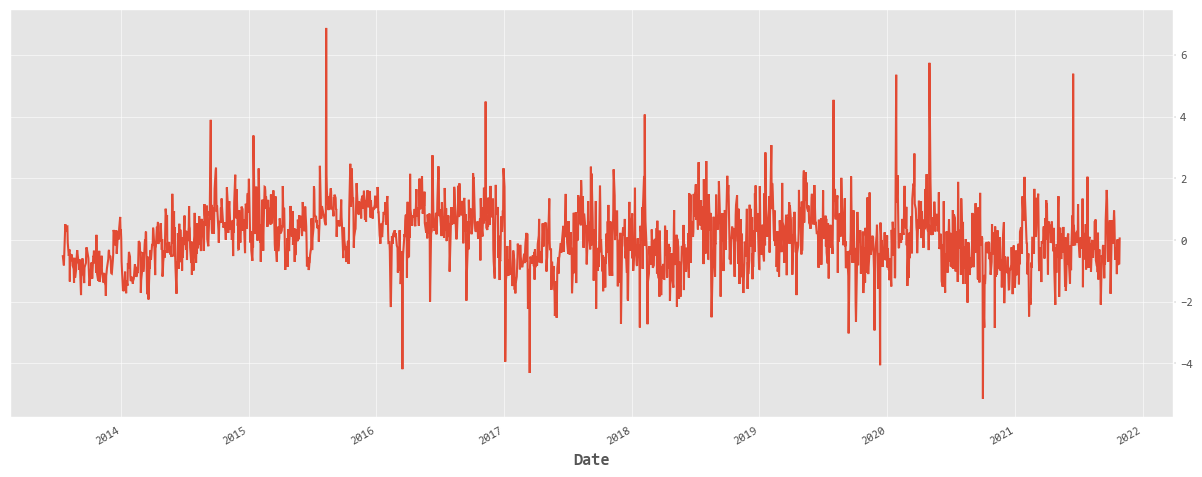

In [125]:
fig, ax = plt.subplots(figsize=(15, 6))
model.std_resid.plot(ax=ax, label = "standarized residuals")

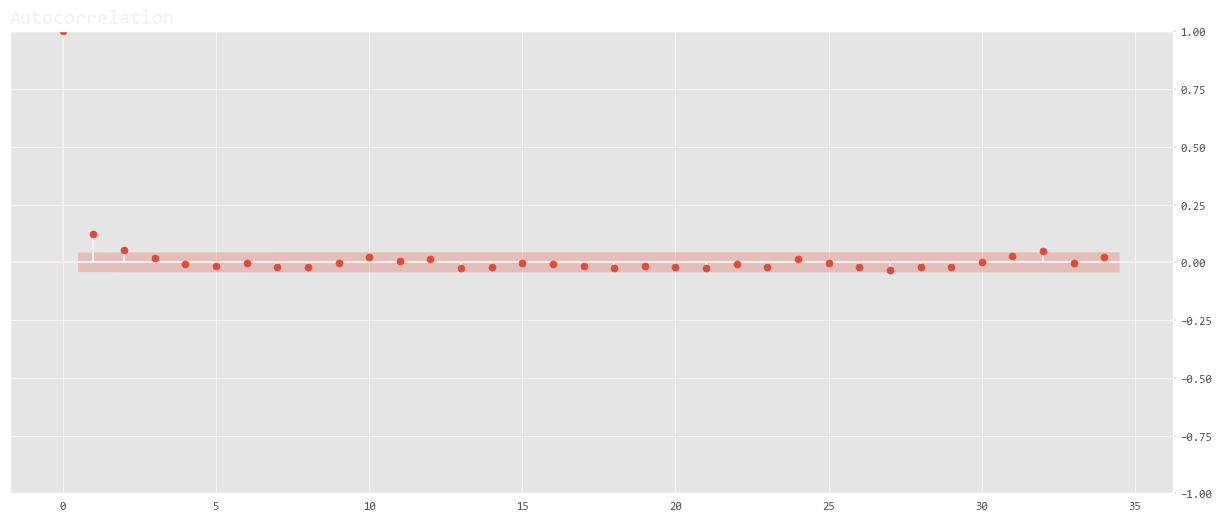

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax =ax);

In [172]:
one_day_forecast = model.forecast(horizon=1, reindex = False).variance**(1/2)
one_day_forecast.iloc[0,0]

0.0068655604085578964

In [173]:
predictions = []
test_size = int(len(spread) * 0.2)

In [176]:
test_size

539

In [174]:
for i in range(test_size):
    y_train = spread.iloc[: -(test_size - i + 1)]
    
    model = arch_model(y_train, p=1, q=1,rescale=False).fit(disp = 0)
    next_pred = model.forecast(horizon=1, reindex = False).variance.iloc[0,0]**(1/2)
    predictions.append(next_pred)

In [178]:
y_test_wfv = pd.Series(predictions, index=spread.tail(test_size).index)

In [182]:
print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.tail()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (539,)


Date
2023-11-24    0.008810
2023-11-27    0.008234
2023-11-28    0.007769
2023-11-29    0.007640
2023-11-30    0.010134
dtype: float64

<Axes: xlabel='Date'>

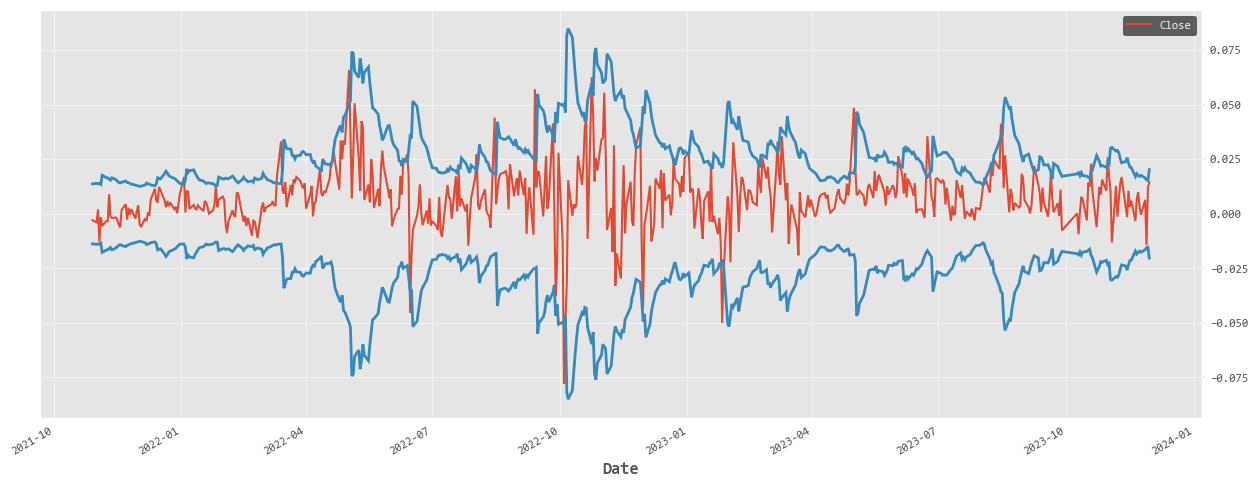

In [186]:
fig, ax = plt.subplots(figsize=(15, 6))
spread.tail(test_size).plot(ax=ax, label="spread")

(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility", linewidth = 2)
(-2 * y_test_wfv).plot(ax=ax, c="C1", linewidth = 2)

In [191]:
test_data = spread[-test_size:]
test_data

,Close
Date,
2021-10-29,-0.0029
2021-11-01,-0.0039
2021-11-02,0.0019
2021-11-03,-0.0128
2021-11-04,-0.0015
...,...
2023-11-24,-0.0004
2023-11-27,0.0064
2023-11-28,-0.0143


In [199]:
y_test_wfv_df = pd.DataFrame(y_test_wfv, columns=['predicted_volatility'])
y_test_wfv_df

,predicted_volatility
Date,
2021-10-29,0.006866
2021-11-01,0.006991
2021-11-02,0.006905
2021-11-03,0.006952
2021-11-04,0.006731
...,...
2023-11-24,0.008810
2023-11-27,0.008234
2023-11-28,0.007769


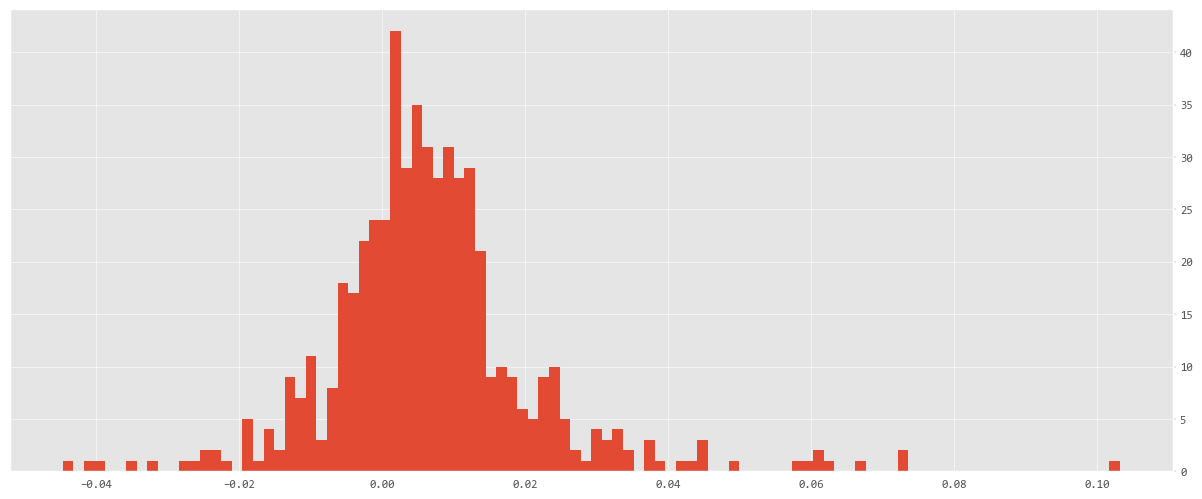

In [203]:
df_eror_test = pd.merge(y_test_wfv_df,test_data, left_index=True, right_index=True, how='inner' )
df_eror_test["error"] = df_eror_test["predicted_volatility"] - df_eror_test["Close"]
plt.hist(df_eror_test["error"], bins = 100);

In [208]:
model = arch_model(spread, p=1, q=1, rescale=False).fit(disp=0)

forecast_horizon = 5
forecast = model.forecast(horizon=forecast_horizon, reindex=False)
forecasted_volatility = np.sqrt(forecast.variance.dropna().values[-1])
forecast_dates = pd.date_range(spread.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_dates

DatetimeIndex(['2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05'],
              dtype='datetime64[ns]', freq='D')

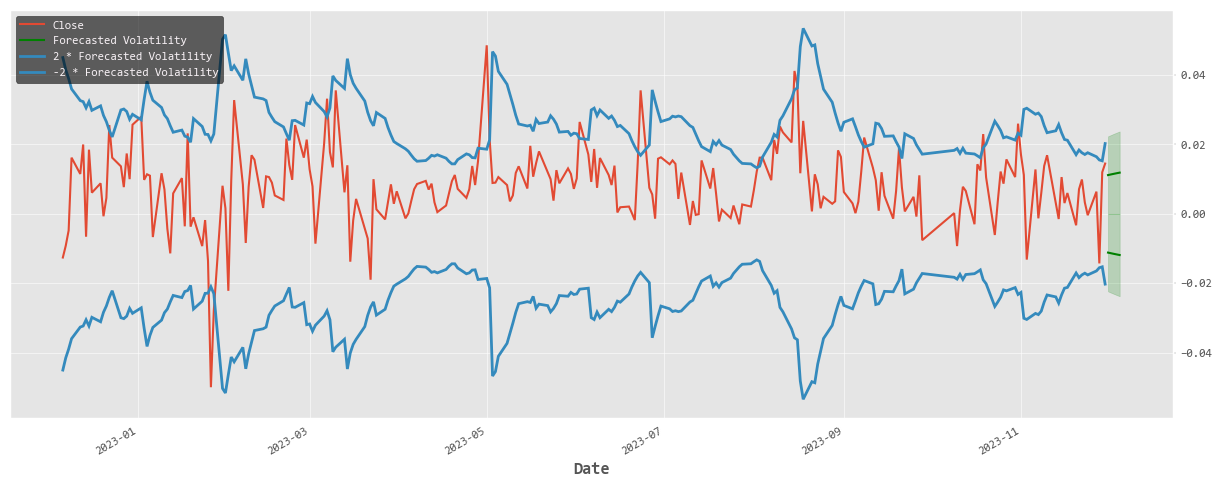

In [221]:
fig, ax = plt.subplots(figsize=(15, 6))

last_250_days = spread.iloc[-252:]
last_250_days.plot(ax=ax, label='Last 252 Trading Days')

ax.plot(forecast_dates, forecasted_volatility, label='Forecasted Volatility', color='green')
ax.plot(forecast_dates, -forecasted_volatility, color='green')

ax.fill_between(forecast_dates, 0, 2 * forecasted_volatility, color='green', alpha=0.2)
ax.fill_between(forecast_dates, 0, -2 * forecasted_volatility, color='green', alpha=0.2)


last_5_days_forecast = (-2 * y_test_wfv)[-252:]
last_5_days_forecast2 = (2 * y_test_wfv)[-252:]
last_5_days_forecast.plot(ax=ax, c="C1", linewidth=2, label='2 * Forecasted Volatility')
last_5_days_forecast2.plot(ax=ax, c="C1", linewidth=2, label='-2 * Forecasted Volatility')
ax.legend()
plt.show()